In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras

In [ ]:
audio_dir = "/content/drive/MyDrive/ML data/cc_wavs"

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#create dataframe with song titles and filepaths

#list of filenames
local_files = os.listdir(audio_dir)
files = []
for file in local_files:
  file = '/content/drive/MyDrive/ML data/cc_wavs/' + file
  files.append(file)
names = [os.path.splitext(filename)[0] for filename in local_files]
cowboy_df = pd.DataFrame({'song_title': names, 'filepath': files})


In [ ]:
cowboy_df

,song_title,filepath
0,AMERIICAN REQUIEM,/content/drive/MyDrive/ML data/cc_wavs/AMERIIC...
1,BLACKBIIRD,/content/drive/MyDrive/ML data/cc_wavs/BLACKBI...
2,16 CARRIAGES,/content/drive/MyDrive/ML data/cc_wavs/16 CARR...
3,PROTECTOR,/content/drive/MyDrive/ML data/cc_wavs/PROTECT...
4,MY ROSE,/content/drive/MyDrive/ML data/cc_wavs/MY ROSE...
5,TEXAS HOLD 'EM,/content/drive/MyDrive/ML data/cc_wavs/TEXAS H...
6,BODYGUARD,/content/drive/MyDrive/ML data/cc_wavs/BODYGUA...
7,JOLENE,/content/drive/MyDrive/ML data/cc_wavs/JOLENE.mp3
8,DAUGHTER,/content/drive/MyDrive/ML data/cc_wavs/DAUGHTE...
9,SPAGHETTII,/content/drive/MyDrive/ML data/cc_wavs/SPAGHET...


In [2]:
sr = 22050
def make_melspec(filepath, sr = sr):
  y, sr = librosa.load(filepath)
  melspec = librosa.feature.melspectrogram(y=y,
                                           sr=sr,
                                           n_fft=2048,
                                           hop_length=512,
                                           n_mels=96,
                                           fmax=sr // 2)
  melspec = librosa.power_to_db(melspec, ref=np.max)
  return melspec

In [ ]:
#make spectrograms
melspec_df = []
for i in range(len(cowboy_df)):
  melspec_df.append(make_melspec(cowboy_df['filepath'][i]))
  print(i, 'songs converted')

0 songs converted
1 songs converted
2 songs converted
3 songs converted
4 songs converted
5 songs converted
6 songs converted
7 songs converted
8 songs converted
9 songs converted
10 songs converted
11 songs converted
12 songs converted
13 songs converted
14 songs converted
15 songs converted
16 songs converted
17 songs converted
18 songs converted
19 songs converted
20 songs converted


In [ ]:
#chop spectrograms into length of 1400
min_length = 1400
songs_final = []
specs = []
for i in range(len(melspec_df)):
  spec = melspec_df[i]
  title = cowboy_df['song_title'][i]
  length = melspec_df[i].shape[1]
  if length <= min_length:
    songs_final.append(title)
    specs.append(spec)
  else:
    for j in range(length // min_length):
      songs_final.append(title)
      specs.append(spec[:, j*min_length:(j+1)*min_length])
#confirm shapes
print('total clips:', len(songs_final))
print('total spectrograms:',len(specs))


total clips: 127
total spectrograms: 127


In [ ]:
eps = 1e-6
specs = np.array(specs).reshape(-1, 96, 1400, 1)
specs = (specs - specs.mean(axis=(1,2,3), keepdims=True)) / \
          (specs.std(axis=(1,2,3), keepdims=True) + eps)

In [ ]:
# Recreate the model, it didn't load properly on it's own
def create_model():
    model = keras.Sequential([
        keras.Input(shape=(96, 1400, 1)),
        keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),

        keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),

        keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),

        keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.BatchNormalization(),

        keras.layers.Lambda(lambda t: tf.reduce_mean(t, axis=1)),

        keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
        keras.layers.Dropout(0.3),
        keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False)),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model()

# Load weights from saved model
# I chose to use the cnn-bilstm because it mispredicted country slightly less
model.load_weights("/content/drive/MyDrive/ML data/spec_model_10class.keras")


In [ ]:
#make predicitons
cowboy_pred = model.predict(specs)
cowboy_pred

4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 12s/step


array([[0.00511622, 0.00823711, 0.00219029, ..., 0.00407377, 0.07275126,
        0.04523774],
       [0.01166795, 0.01517404, 0.00292544, ..., 0.00597793, 0.094837  ,
        0.04746213],
       [0.00595931, 0.01039533, 0.00170251, ..., 0.00428813, 0.08680768,
        0.0408685 ],
       ...,
       [0.01467935, 0.01010433, 0.0044724 , ..., 0.00621127, 0.12367524,
        0.05056592],
       [0.06298236, 0.06814774, 0.02166663, ..., 0.01217442, 0.07386258,
        0.06518824],
       [0.03153525, 0.0611301 , 0.01217604, ..., 0.01996288, 0.12358983,
        0.11704627]], dtype=float32)

In [ ]:
len(cowboy_pred)

127

In [ ]:
#create dataframe to store results in
clips_df = pd.DataFrame({'song_title': songs_final})
clips_df

,song_title
0,AMERIICAN REQUIEM
1,AMERIICAN REQUIEM
2,AMERIICAN REQUIEM
3,AMERIICAN REQUIEM
4,AMERIICAN REQUIEM
...,...
122,SWEET HONEY BUCKIIN'
123,AMEN
124,AMEN
125,AMEN


In [ ]:
#add primary genre of each clip to dataframe
genres = ['ambient',
          'classical_orchestral',
          'electronic_edm',
          'folk_country',
          'funk_soul_rnb',
          'hiphop_rap',
          'jazz_fusion',
          'metal',
          'pop',
          'rock_punk']

primary_genre = []
for i in range(len(cowboy_pred)):
  primary_genre.append(genres[np.argmax(cowboy_pred[i])])
clips_df['primary_genre'] = primary_genre

In [ ]:
prevalence_df = pd.DataFrame({'song_title': names})
genres_in = clips_df['primary_genre'].unique()
#create empty dataframe
for genre in genres_in:
  prevalence_df[genre] = 0
#update genre values based on samples
for i in range(len(clips_df)):
  title = clips_df['song_title'][i]
  genre = clips_df['primary_genre'][i]
  prevalence_df.loc[prevalence_df['song_title'] == title, genre] += 1


In [ ]:
#normalize data so predicted genre has '1'
prevalence_df[genres_in] = prevalence_df[genres_in].div(prevalence_df[genres_in].sum(axis=1), axis=0)

In [ ]:
#dataframe of final predictions
prevalence_df

,song_title,folk_country,hiphop_rap,funk_soul_rnb,pop,jazz_fusion
0,AMERIICAN REQUIEM,1.000000,0.000000,0.000000,0.000000,0.000000
1,BLACKBIIRD,1.000000,0.000000,0.000000,0.000000,0.000000
2,16 CARRIAGES,1.000000,0.000000,0.000000,0.000000,0.000000
3,PROTECTOR,1.000000,0.000000,0.000000,0.000000,0.000000
4,MY ROSE,1.000000,0.000000,0.000000,0.000000,0.000000
5,TEXAS HOLD 'EM,1.000000,0.000000,0.000000,0.000000,0.000000
6,BODYGUARD,1.000000,0.000000,0.000000,0.000000,0.000000
7,JOLENE,1.000000,0.000000,0.000000,0.000000,0.000000
8,DAUGHTER,1.000000,0.000000,0.000000,0.000000,0.000000
9,SPAGHETTII,0.750000,0.250000,0.000000,0.000000,0.000000


In [ ]:
prevalence_df = prevalence_df.iloc[::-1]  #makes song order show up correctly for graph

<Figure size 1000x600 with 0 Axes>

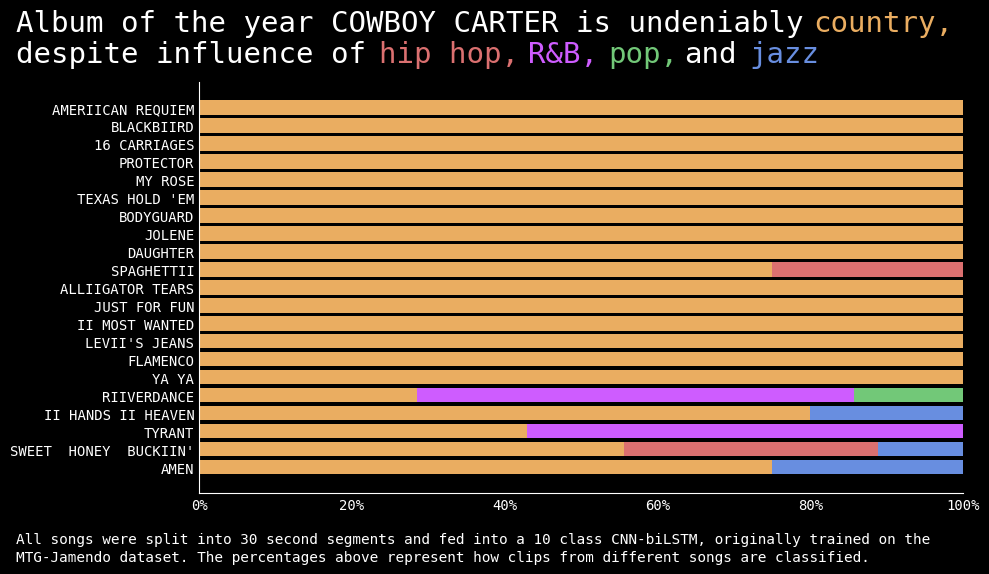

In [ ]:
#Make graph to display findings
plt.rcParams['font.family'] = ['monospace']
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))

#color dictionary
genre_colors = {'folk_country': '#eaad61',
                'hiphop_rap': '#db7070',
                'funk_soul_rnb': '#ce5cff',
                'pop': '#72c878',
                'jazz_fusion': '#688ee0'}

#create stacked horizontal bar chart for each song
plt.figure(figsize=(10, 6))

# cumulative sum to set left position for stacking
left = np.zeros(len(prevalence_df))

for genre in genres_in:
    plt.barh(prevalence_df['song_title'], prevalence_df[genre],
             left=left, label=genre, color=genre_colors[genre])
    left += prevalence_df[genre]  # update left for next genre

# remove tickmarks
plt.gca().tick_params(axis='x', which='both', length=0)
plt.gca().tick_params(axis='y', which='both', length=0)

#despine
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#format x labels as percent
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

#create legend encoded title
plt.text(-0.24, 24.7, 'Album of the year COWBOY CARTER is undeniably', fontsize=21, ha='left', va='center')
plt.text(.804, 24.7, 'country,', color = genre_colors['folk_country'],fontsize=21, ha='left', va='center')
plt.text(-0.24, 23, 'despite influence of',fontsize=21, ha='left', va='center')
plt.text(0.235, 23, 'hip hop,',fontsize=21, color = genre_colors['hiphop_rap'], ha='left', va='center')
plt.text(0.43, 23, 'R&B,',fontsize=21, color = genre_colors['funk_soul_rnb'], ha='left', va='center')
plt.text(0.535, 23, 'pop,',fontsize=21, color = genre_colors['pop'], ha='left', va='center')
plt.text(0.635, 23, 'and',fontsize=21, ha='left', va='center')
plt.text(0.72, 23, 'jazz',fontsize=21, color = genre_colors['jazz_fusion'], ha='left', va='center')

#add caption
plt.text(-0.24, -4, 'All songs were split into 30 second segments and fed into a 10 class CNN-biLSTM, originally trained on the',fontsize=10.4, ha='left', va='center')
plt.text(-0.24, -5, 'MTG-Jamendo dataset. The percentages above represent how clips from different songs are classified.',fontsize=10.4, ha='left', va='center')
plt.tight_layout()
plt.show()
#Album of the year cowboy carter is undeniably country, despite inspiration from other genres...